# Importando librerías

In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


# Problema

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo (aproximadamente 17,9 millones de muertes cada año, lo que representa el 31 % de todas las muertes en todo el mundo). Cuatro de cada 5 muertes por ECV se deben a ataques cardíacos y accidentes cerebrovasculares, y un tercio de estas muertes ocurren prematuramente en personas menores a 70 años. La insuficiencia cardíaca es un evento común causado por ECV y este conjunto de datos contiene 11 características que pueden usarse para predecir una posible enfermedad cardíaca.

Las personas con enfermedades cardiovasculares o de alto riesgo cardiovascular (por la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan una detección y manejo temprano en el que un modelo de aprendizaje automático puede ser de gran ayuda.

# Los Atributos incluyen:
- Age: edad del paciente [años]
- Sex: sexo del paciente [M: Masculino, F: Femenino]
- ChestPainType: tipo de dolor torácico [TA: Angina típica, ATA: Angina atípica, NAP: Dolor no anginoso, ASY: Asintomático]
- RestingBP: presión arterial en reposo [mm Hg]
- Cholesterol: colesterol sérico [mm/dl]
- FastingBS: glucemia en ayunas [1: si BS en ayunas > 120 mg/dl, 0: en caso contrario]
- RestingECG en reposo: resultados del electrocardiograma en reposo [Normal: normal, ST: con anomalías en la onda ST-T (inversión de la onda T y/o elevación o depresión del ST > 0,05 mV), HVI: hipertrofia ventricular izquierda probable o definitiva según los criterios de Estes]
- MaxHR: frecuencia cardíaca máxima alcanzada [Valor numérico entre 60 y 202]
- ExerciseAngina: angina inducida por el ejercicio [Y: Sí, N: No]
- Oldpeak: oldpeak = ST [Valor numérico medido en depresión]
- ST_Slope: la pendiente del segmento ST del ejercicio máximo [Up: pendiente ascendente, Plain: plana, Down: pendiente descendente]
- HeartDisease: clase de salida [1: enfermedad cardíaca, 0: normal]

** Oldpeak y ST_Slope están relacionados con los cambios en el segmento ST del electrocardiograma (ECG), que pueden ser indicadores de isquemia miocárdica (falta de flujo sanguíneo al corazón) durante el esfuerzo físico

# Usaremos el dataset de predicción de ataques cardíacos

In [ ]:
#df=pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df=pd.read_csv("https://raw.githubusercontent.com/gustavovazquez/datasets/main/heart.csv")
df.head()



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


La función describe() en pandas muestra un resumen de estadísticas (la media, la desviación estándar, los valores mínimo y máximo y los cuantiles de los datos).

In [ ]:
df.shape

(918, 12)

In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Veamos los tipos de los datos del dataframe

In [ ]:
df.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


Como podemos ver, los tipos datos 'string' tienen la forma de un objeto, entonces debemos convertirlos nuevamente en una cadena.

In [ ]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [ ]:
df.dtypes

,0
Age,int64
Sex,string[python]
ChestPainType,string[python]
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,string[python]
MaxHR,int64
ExerciseAngina,string[python]
Oldpeak,float64


## Trabajando con columnas categóricas

In [ ]:
# extraemos los nombres de las columnas categóricas
string_col=df.select_dtypes("string").columns.to_list()
print(string_col)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [ ]:
# extraemos los nombres de las columnas numéricas
num_col=df.columns.to_list()   # copiamos todas
for col in string_col:
    num_col.remove(col)        # y sacamos todas las que eran strings (es decir, nos quedamos con el complemento)
# también sacamos la columna target
num_col.remove("HeartDisease")
print(num_col)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


In [ ]:
df.describe().T
# en el caso de un dataframe compuesto por columnas numéricas y string, solo retornará estadísticas de las numéricas

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


# Análisis de datos exploratorio

## Matriz de correlación
Es necesario eliminar las variables correlacionadas para mejorar el modelo.

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
5     39   M           NAP        120          339          0     Normal   
6     45   F           ATA        130          237          0     Normal   
7     54   M           ATA        110          208          0     Normal   
8     37   M           ASY        140          207          0     Normal   
9     48   F           ATA        120          284          0     Normal   
10    37   F           NAP        130          211          0     Normal   
11    58   M           ATA        136          164          0         ST   
12    39   M

<Axes: >

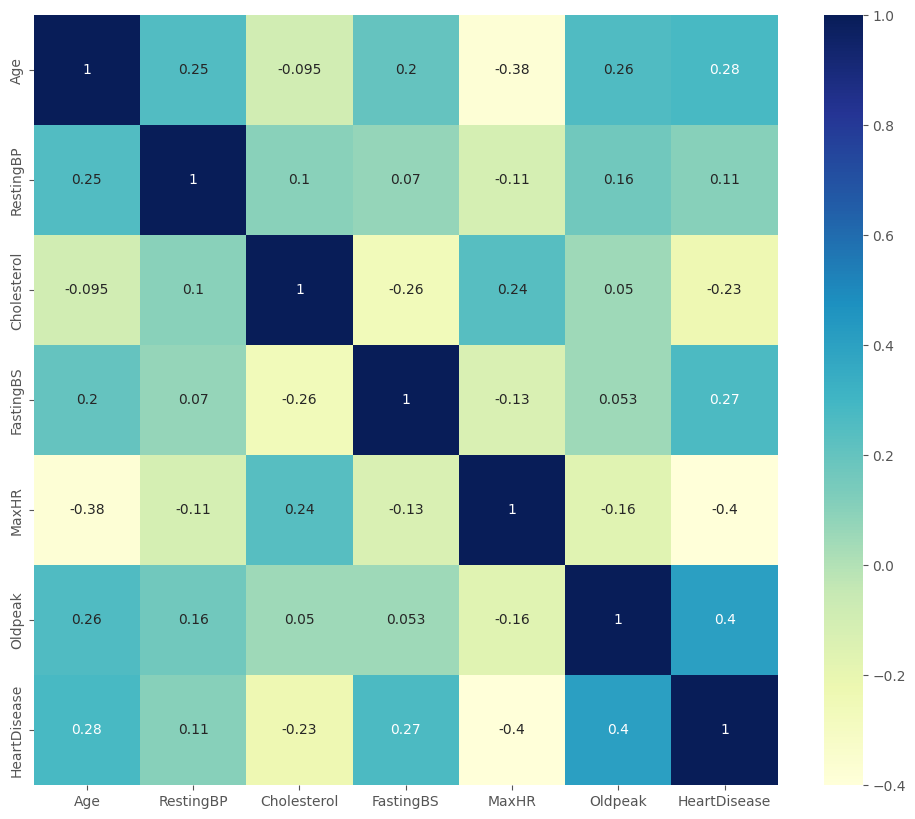

In [ ]:
import seaborn as sns
print(df)
corr = df.corr(numeric_only=True)
# ATENCIÓN !!
# documentación del método corr - parámetro numeric_only:
# Deprecated since version 1.5.0: The default value of numeric_only will be False in a future version of pandas.
# (originalmente por default era )
# Changed in version 2.0.0: The default value of numeric_only is now False.
# esto es un ejemplo de la necesidad de entornos para garantizar la correcta ejecución de código

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="YlGnBu")


En principio no hay indicios de fuerte correlación entre las variables numéricas

In [ ]:
# Ahora vemos el caso de variables categóricas
fig=px.histogram(df,
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribución de los ataques cardíacos",
                 barmode="group")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="ChestPainType",
                 color="Sex",
                 hover_data=df.columns,
                 title="Tipos de dolor de pecho"
                )
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="Sex",
                 hover_data=df.columns,
                 title="Tasa de géneros en el dataset")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="RestingECG",
                 hover_data=df.columns,
                 title="Distribución de ECG en reposo")
fig.show()

Para mostrar múltiples distribuciones por pares en un conjunto de datos, podemos usar la función pairplot(). Esto muestra la relación para las combinaciones de n variables tomadas de a dos (n, 2) del DataFrame (los gráficos diagonales son los gráficos de distribución para cada clase).

[]

<Figure size 1500x1000 with 0 Axes>

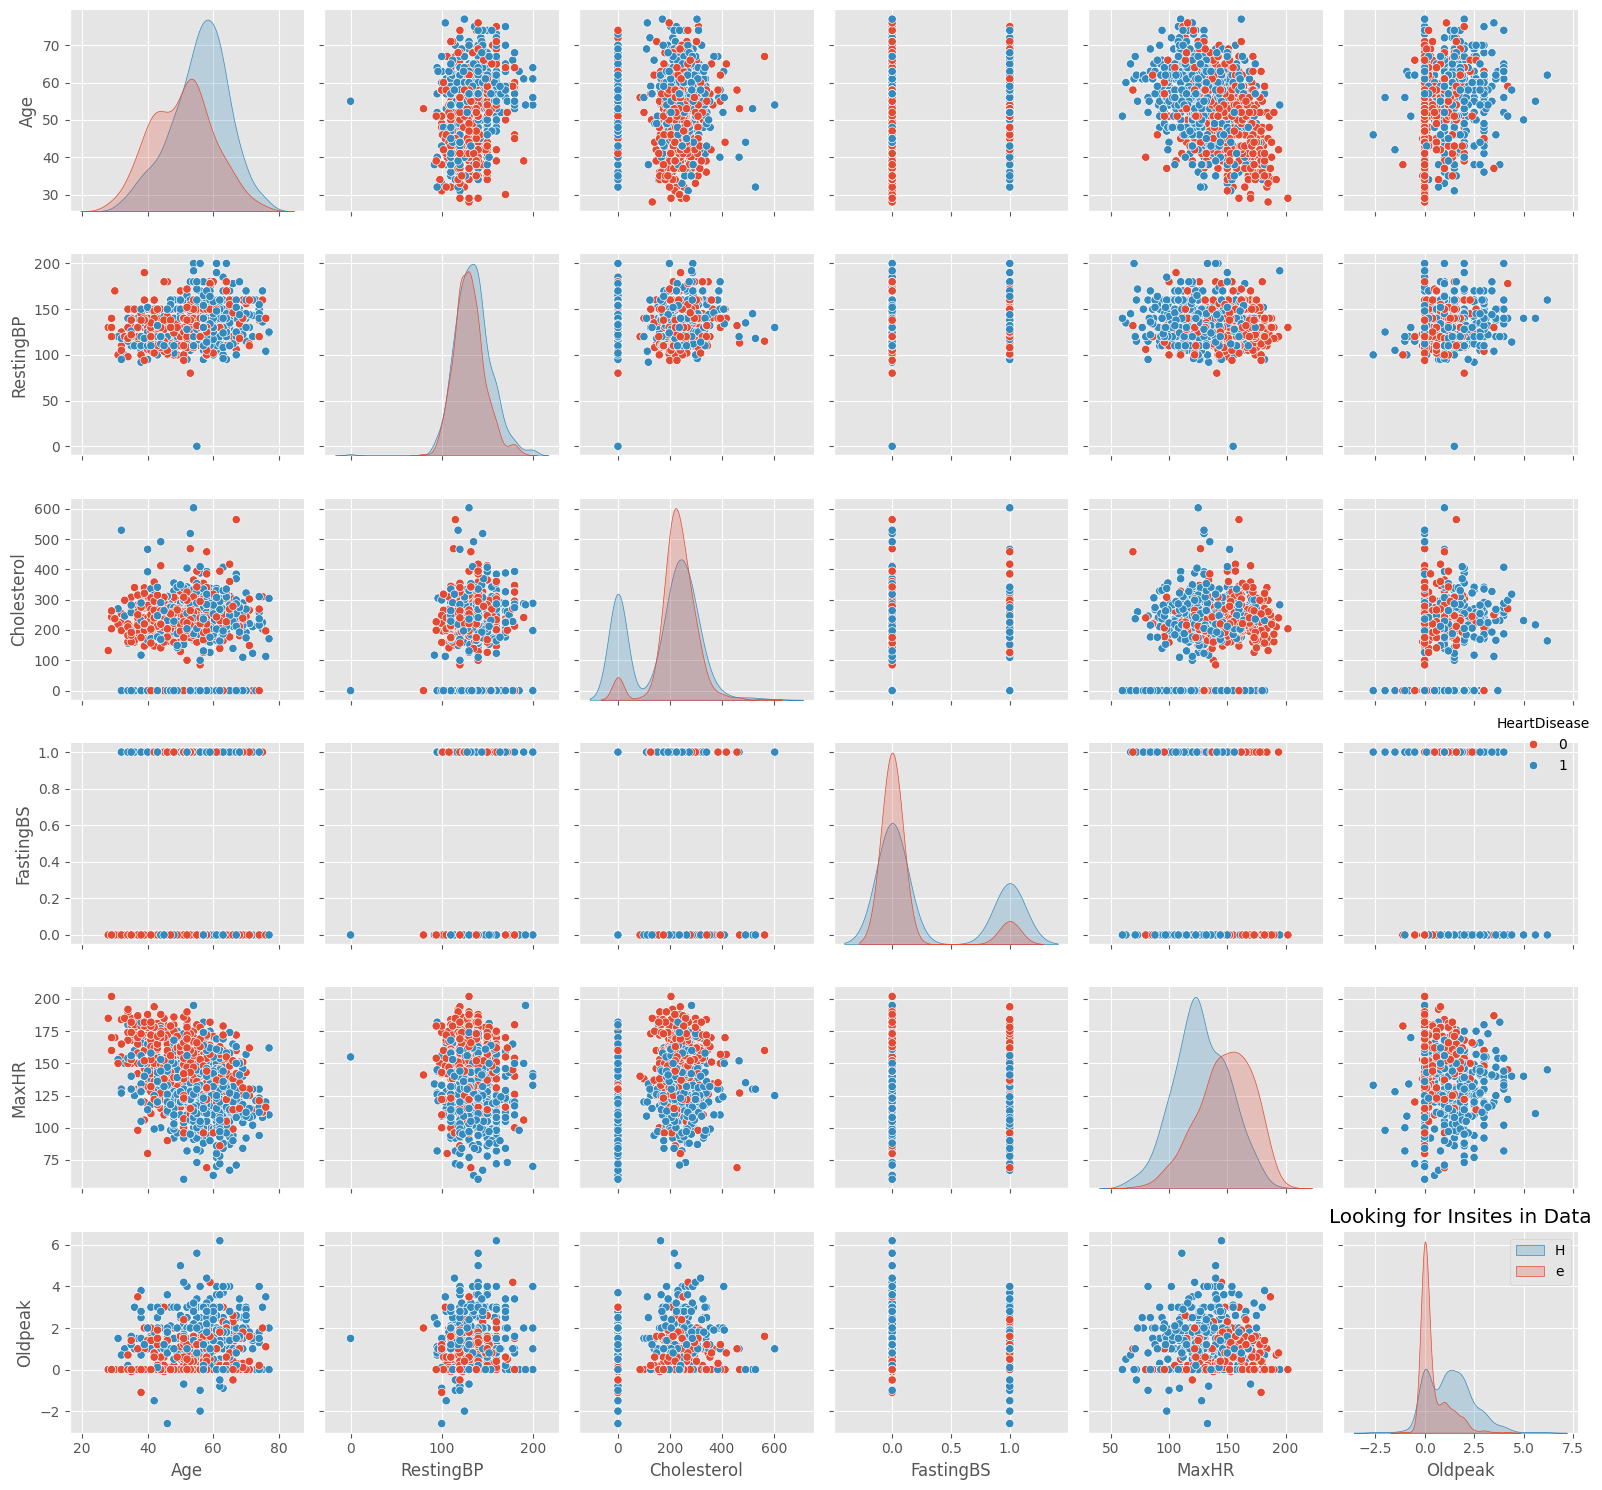

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

podemos ver el histograma de cada variable y superponer la kernel density estimation (KDE) para una mejor visualización ("suaviza" los histogramas)

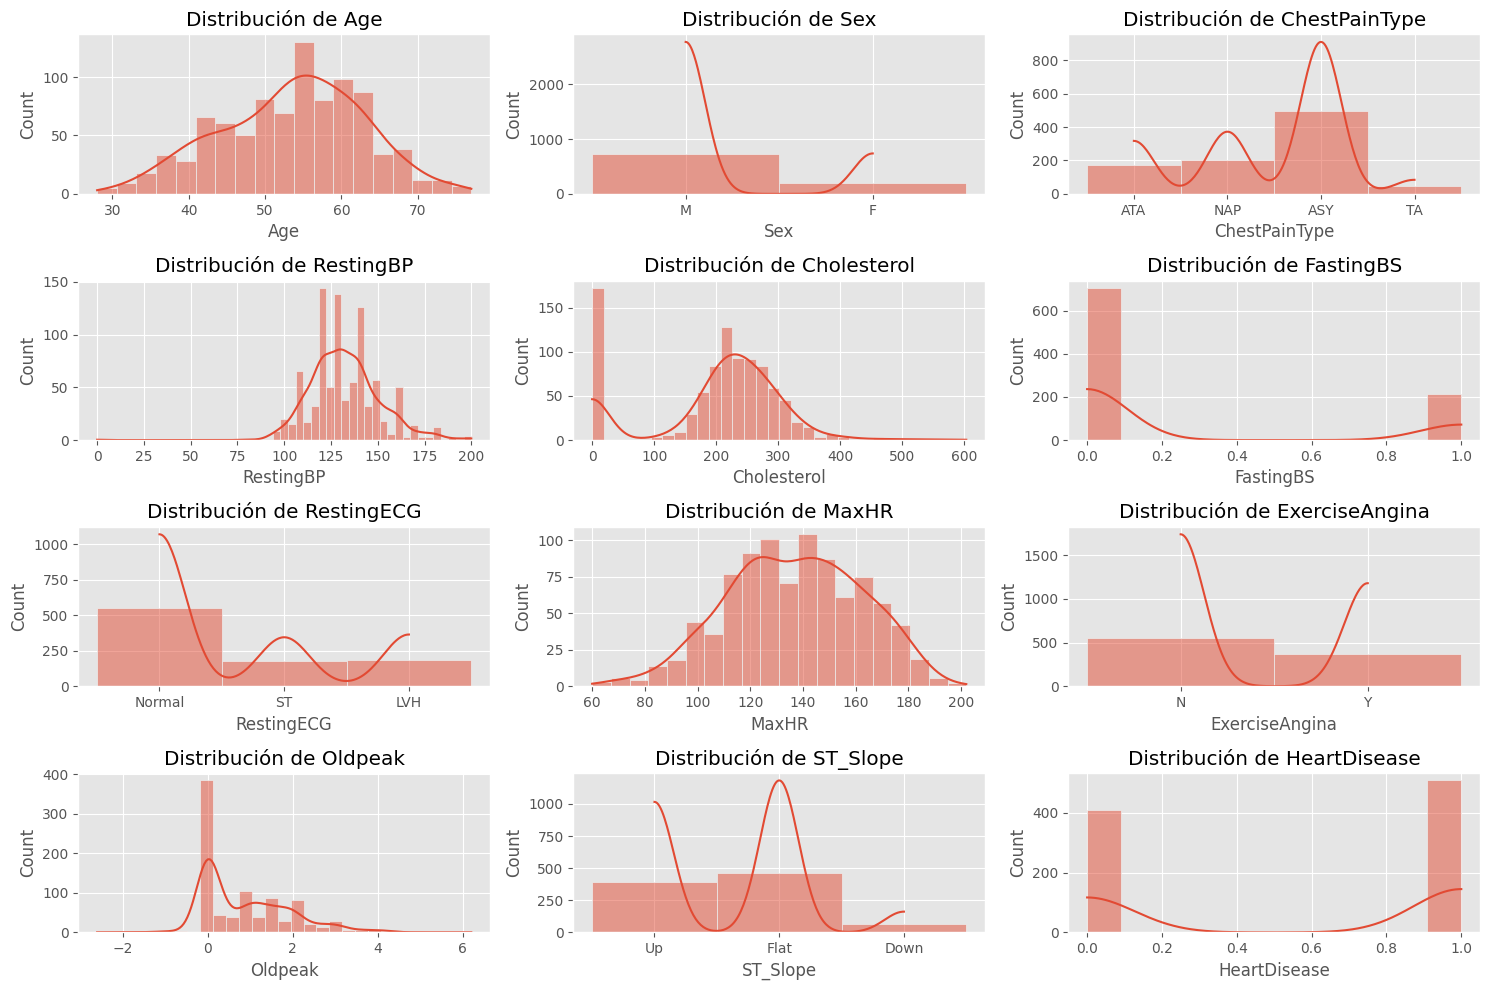

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribución de {col}")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()



Un diagrama boxplot muestra la distribución de datos cuantitativos de una manera que facilita las comparaciones entre variables. El cuadro muestra los cuartiles del conjunto de datos mientras que los extremos se extienden para mostrar el resto de la distribución. El diagrama de caja es una forma estandarizada de mostrar la distribución de datos basada en el resumen de cinco métricas:

- Mínimo
- Primer cuartil
- mediana
- Tercer cuartil
- Máximo.

En el diagrama de caja más simple, el rectángulo central abarca desde el primer cuartil hasta el tercer cuartil (el rango intercuartílico o IQR). Un segmento dentro del rectángulo muestra la mediana y los "extremos" arriba y abajo del cuadro muestran las ubicaciones del mínimo y el máximo.

In [ ]:

fig = px.box(df,y="Age",x="HeartDisease",title=f"Distrubution of Age")
fig.show()

In [ ]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distrubution of RestingBP",color="Sex")
fig.show()

In [ ]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distrubution of Cholesterol")
fig.show()

OBS: un aspecto a destacar es la presencia del valor 0 en el caso de persona sana (HeartDisease=0). Esto demuestra lo fundamental del **conocimiento del problema o conocimiento del negocio**, dado que solo expertos pueden determinar qué es un valor extremo (pero posible) y qué es un valor erróneo que debe considerarse como outlier. El boxplot es una herramienta útil para identificar estas situaciones.

In [ ]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distrubution of Oldpeak")
fig.show()

In [ ]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distrubution of MaxHR")
fig.show()

# Preprocesamiento

# 1. Valores nulos:
Es de esperar que existan pocos valores nulos en un dataset. Sin embargo la mayoría de los métodos trabajan sobre datasets con valores no nulos

> En python NULL se representa con NaN. Así que no se confunda entre estos dos, se pueden usar indistintamente.


In [ ]:
# Checking for Type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    string 
 2   ChestPainType   918 non-null    string 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    string 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    string 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    string 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), string(5)
memory usage: 86.2 KB


In [ ]:
# Checking for NULLs in the data
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


# 2. Escalado
Lo realizaremos en el pipeline

# 3. Manejo de variables categóricas

Las variables categóricas contienen valores nominales y se pueden clasificar en dos tipos principales:
- Nominal
- Ordinales

Las variables nominales son variables que tienen dos o más categorías que no tienen ningún tipo de orden asociado a ellas. Por ejemplo, si el género se clasifica en dos grupos, es decir, masculino y femenino, se puede considerar como una variable nominal. Las variables ordinales, por otro lado, tienen “niveles” o categorías con un orden particular asociado a ellas. Por ejemplo, una variable categórica ordinal puede ser una característica con tres niveles diferentes: bajo, medio y alto. En este caso, el orden es importante.

En los casos ordinales, si la distancia de las categorías es equivalente entonces podemos dejar el orden en forma numérica (ejemplo, bajo, medio alto puede ser codificado como 1, 2, 3). En casos nominales debemos utilizar la técnica de One-Hot encoding (OBS: algunas implementaciones, sobre todo en algoritmos basados en árboles, admiten valores nominales directos, por lo tanto no se necesita One-Hot enconding).

- One-Hot-Encoding tiene la ventaja de que el resultado es binario en lugar de ordinal y que todo se encuentra en un espacio vectorial ortogonal.
- La desventaja es que para una alta cardinalidad, el espacio de características puede explotar rápidamente y tenemos el problema de la maldición de la dimensionalidad (podría reducirse este efecto aplicando PCA).

In [ ]:
df[string_col].head()
print(string_col)
for col in string_col:
    print(f"Distribución de los valores en las variables categóricas -  {col}: ")
    print(df[col].value_counts())

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Distribución de los valores en las variables categóricas -  Sex: 
Sex
M    725
F    193
Name: count, dtype: Int64
Distribución de los valores en las variables categóricas -  ChestPainType: 
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: Int64
Distribución de los valores en las variables categóricas -  RestingECG: 
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: Int64
Distribución de los valores en las variables categóricas -  ExerciseAngina: 
ExerciseAngina
N    547
Y    371
Name: count, dtype: Int64
Distribución de los valores en las variables categóricas -  ST_Slope: 
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: Int64


In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:

## creamos el One-Hot-Encoding (solo lo hace para las categóricas)
df_encoded=pd.get_dummies(df,columns=string_col,drop_first=True)  # get_dummies
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [ ]:
# extraemos el target
target="HeartDisease"
y=df_encoded[target].values
df_encoded.drop(target,axis=1,inplace=True)
#df_categoricas=pd.concat([df_categoricas,df[target]],axis=1)
df_encoded.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True


# Fase de entrenamiento :


In [ ]:
'''
Versión con k-fold validation

# Crear el escalador MinMax
scaler = MinMaxScaler()

# Crear el modelo de regresión logística
model = LogisticRegression()

steps = [
    ('scaler', MinMaxScaler()),    # Escaladoxcon MinMax
    ('classifier', LogisticRegression())    # Modelo
]

# y construimos el objeto pipeline
pipeline = Pipeline(steps)
# Definir el número de splits para la validación cruzada (k)
kf = KFold(n_splits=10)

# Realizar validación cruzada y calcular las métricas utilizando el pipeline
accuracy_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring='f1')

# Obtener predicciones para la matriz de confusión utilizando el pipeline
# (notar que aplicamos el pipeline)
y_pred = cross_val_predict(pipeline, df_encoded, y, cv=kf)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred)


# Imprimir los resultados
print("Accuracy:", np.mean(accuracy_scores))
print("Precision:", np.mean(precision_scores))
print("Recall:", np.mean(recall_scores))
print("F1 Score:", np.mean(f1_scores))
print("Confusion Matrix:\n", conf_matrix)
'''

'\nVersión con k-fold validation\n\n# Crear el escalador MinMax\nscaler = MinMaxScaler()\n\n# Crear el modelo de regresión logística\nmodel = LogisticRegression()\n\nsteps = [\n    (\'scaler\', MinMaxScaler()),    # Escaladoxcon MinMax\n    (\'classifier\', LogisticRegression())    # Modelo\n]\n\n# y construimos el objeto pipeline\npipeline = Pipeline(steps)\n# Definir el número de splits para la validación cruzada (k)\nkf = KFold(n_splits=10)\n\n# Realizar validación cruzada y calcular las métricas utilizando el pipeline\naccuracy_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring=\'accuracy\')\nprecision_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring=\'precision\')\nrecall_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring=\'recall\')\nf1_scores = cross_val_score(pipeline, df_encoded, y, cv=kf, scoring=\'f1\')\n\n# Obtener predicciones para la matriz de confusión utilizando el pipeline\n# (notar que aplicamos el pipeline)\ny_pred = cross_

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Crear el pipeline con escalador y modelo
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),    # Escalado con MinMax
    ('classifier', LogisticRegression())    # Modelo
])

# Entrenar el modelo con el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8876811594202898
Precision: 0.8860759493670886
Recall: 0.9150326797385621
F1 Score: 0.9003215434083601
Confusion Matrix:
 [[105  18]
 [ 13 140]]
